<a href="https://colab.research.google.com/github/wingyiuc/COMP3359_AI_Ap_Project/blob/master/Walk_forward_Models_(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Getting started

In [1]:
""" Prepare Notebook for Google Colab """
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify directory of course materials in Google Drive
module_dir = '/content/drive/My Drive/COMP3359 AI Applications Group Project'

# Add course material directory in Google Drive to system path, for importing .py files later
# (Ref.: https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab)
import sys
sys.path.append(module_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# !pip install fastparquet
!pip install ta
!pip install PyWavelets

  Created wheel for ta: filename=ta-0.5.22-cp36-none-any.whl size=24340 sha256=65b87a52375e337cc0902d5e3300df603ab41260482c2395be7a2ddaa233eb0f
  Stored in directory: /root/.cache/pip/wheels/87/0c/4d/646b17c066f52a8f6923b17ef23839a19584ee2b4d55238465
Successfully built ta


In [3]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import glob
import requests
import matplotlib
import math
import ta
import pywt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Softmax
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten
from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
from random import choices
from sklearn.utils import shuffle

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# data_dir = os.path.join(module_dir, "Downloaded data/Daily data//")
# data_dir = os.path.join(module_dir, "Cryptocurrency_price_history/")

processed_data_dir = os.path.join(module_dir, "Cryptocurrency data/Processed data/")
# processed_data_dir = os.path.join(module_dir, "Downloaded data/Daily data/Processed data/")
os.listdir(processed_data_dir)

['BTC_processed_conservative.csv',
 'DASH_processed_conservative.csv',
 'ETH_processed_conservative.csv',
 'DOGE_processed_conservative.csv',
 'LTC_processed_conservative.csv',
 'USDT_processed_conservative.csv',
 'NVC_processed_conservative.csv',
 'NMC_processed_conservative.csv',
 'FTC_processed_conservative.csv',
 'TRC_processed_conservative.csv',
 'PPC_processed_conservative.csv',
 'IXC_processed_conservative.csv',
 'FRC_processed_conservative.csv',
 'BTB_processed_conservative.csv',
 'WDC_processed_conservative.csv',
 'BTC_processed.csv',
 'ETH_processed.csv',
 'DOGE_processed.csv',
 'USDT_processed.csv',
 'DASH_processed.csv',
 'NMC_processed.csv',
 'PPC_processed.csv',
 'LTC_processed.csv',
 'IXC_processed.csv',
 'NVC_processed.csv',
 'TRC_processed.csv',
 'WDC_processed.csv',
 'BTB_processed.csv',
 'FRC_processed.csv',
 'FTC_processed.csv']

# Global variables & functions

In [0]:
tickers = ['BTC', 'ETH', 'DOGE', 'DASH', "LTC", "NMC", "PPC", "NVC", "FTC", "WDC"]
BATCH_SIZE = 256
BUFFER_SIZE = 10000
PAST_HISTORY = 15

In [0]:
# features_considered  = ['close', 'high', 'low', 'open', 'volumefrom', 'volumeto',
#        '12EMA', '50EMA', '100EMA', 'minusDI',
#        'plusDI', 'MACD', 'MACDsignal', 'RSI', 'StoOsci', 'StoOsci_signal',
#        'BB_hband', 'BB_lband', 'ATR', 'ADI', 'MFI']
# features_considered  = ['close', 'high', 'low', 'open','MACD','MACDsignal']
features_considered  = ['close', 'high', 'low', 'open', 'volumeto',
      '12_100EMA','50_100EMA', '100EMA', 'minusDI',
      'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal',
      'BB_hband', 'BB_lband', 'ATR', 'ADI', 'MFI']
y_labels = ['buy_signal', 'sell_signal', 'hold_signal']
signals = ['buy', 'sell', 'hold']

In [0]:
def preprocess_dataframe(df,features_considered):
  df = df.dropna()
  features = df[features_considered]
  df['time'] = pd.to_datetime(df['time'])
  features.index = df['time']


  outcome = df[y_labels]
  df['time'] = pd.to_datetime(df['time'])
  outcome.index = df['time']

  return features, outcome

In [0]:
def preprocess_features(features,train_split):
  
  x_dataset = features.values
  # train_split = int(features.shape[0]*0.75)

  # standardize the dataset using the mean and standard deviation of the training data.
  data_mean = x_dataset[:train_split].mean(axis=0)
  data_std = x_dataset[:train_split].std(axis=0)
  x_dataset = (x_dataset-data_mean)/data_std

  # standardize the x_dataset using minmax scaler
  # data_max = x_dataset[:train_split].max(axis=0)
  # data_min = x_dataset[:train_split].min(axis=0)
  # x_dataset = (x_dataset-data_min)/(data_max - data_min)

  # Wavelet transform
  # coeffs, freqs = pywt.cwt(x_dataset,scales=np.arange(1,2),wavelet='morl')
  # x_dataset = coeffs.reshape(-1, coeffs.shape[-1])

  return x_dataset

def preprocess_outcome(outcome):
  return outcome.values

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size):
  start_index = start_index + history_size
  labels = target[start_index: end_index]
  data = []
  
  
  if end_index is None:
    end_index = len(dataset) 

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

  return np.array(data), labels

In [0]:
def decode(datum):
    return np.argmax(datum)
def transform_y(y_val):
  y_true = []
  for i in range(y_val.shape[0]):
      y_true.append(decode(y_val[i]))
  y_true = np.array(y_true).astype(int)
  y_true = y_true.tolist()
  return y_true

In [0]:
from keras.utils import np_utils
import keras.backend as K
from itertools import product
import functools

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.expand_dims(y_pred_max, 1)
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):

        final_mask += (K.cast(weights[c_t, c_p],K.floatx()) * K.cast(y_pred_max_mat[:, c_p] ,K.floatx())* K.cast(y_true[:, c_t],K.floatx()))
    return K.categorical_crossentropy(y_pred, y_true) * final_mask
w_array = np.ones((3,3))
w_array[0,1] = 1.2   # buy becomes sell
w_array[1,0] = 1.2   # sell becomes buy
ncce = functools.partial(w_categorical_crossentropy, weights=w_array)
ncce.__name__ ='w_categorical_crossentropy'

In [0]:
def create_model(x_train):
  """ Construct Classifier Model """
  # Construct a neural network 
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(58, input_shape=x_train.shape[-2:], return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(29, return_sequences=False),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  # Compile model
  # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.compile(loss=ncce, optimizer='adam', metrics=['accuracy'])

  # Show model structure
  # print(model.summary())
  return model

In [0]:
def create_CNN_model(x_train, y_train):
  """ Construct CNN Classifier Model """

  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
  model = Sequential()
  model.add(Conv1D(filters=12, kernel_size=2, activation='relu', padding='same', input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(filters=10, kernel_size=2, activation='relu', padding='same', input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(filters=6, kernel_size=2, padding='same', activation='relu'))
  model.add(Dropout(0.1))
  model.add(MaxPooling1D(pool_size=2, strides=2,))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))

  # Compile model
  # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
  model.compile(loss=ncce, optimizer='adam', metrics=['acc'])
  return model

In [0]:
def fit_model(model, train_data, val_data):
  EPOCHS = 10
  # CLASS_WEIGHT = {0:1, 1:1, 2:1.5} # Give hold more class weight
  batch_size = BATCH_SIZE
  EVALUATION_INTERVAL = 200
  history = model.fit(train_data, epochs=EPOCHS,
                      # class_weight = CLASS_WEIGHT,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data,
                      batch_size = batch_size,
                      # verbose=2,
                      validation_steps=50)
  # model.reset_states() #?
  return model, history

In [0]:
def fit_CNN_model(model, x_train, y_train,x_val, y_val):
  EPOCHS = 10
  CLASS_WEIGHT = {0:1, 1:1, 2:2} # Give hold more class weight
  batch_size = BATCH_SIZE
  history = model.fit(x_train, y_train, validation_split=0.25, 
                      # class_weight = CLASS_WEIGHT,
                      epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
  _, accuracy = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)
  # model.reset_states() #?
  return model, history

In [0]:
def model_predict(model, input_data):
  """
  Output: predicted values in [1, 1, 1, 1, 1, ...] shape
  """
  probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
  predictions = probability_model.predict(input_data)
  predictions = np.argmax(predictions, axis = 1).astype(int)
  predictions =  list(predictions)
  return predictions

In [0]:
def CNN_model_predict(model, input_data):
  """
  Output: predicted values in [1, 1, 1, 1, 1, ...] shape
  """
  probability_model = Sequential([model, Softmax()])
  predictions = probability_model.predict(input_data)
  predictions = np.argmax(predictions, axis = 1).astype(int)
  predictions =  list(predictions)
  return predictions

In [0]:
def get_begin_end_dates(features, models, past_history):
  all_indices = list(features.index)
  # subtract past_history days from begin_dates as input 
  begin_dates = pd.DataFrame([all_indices[all_indices.index(i)-past_history] for i in models.index],columns=["date"])
  begin_dates = begin_dates.set_index('date').index
  # begin_dates = models.index
  end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))
  return begin_dates, end_dates

## Walkforward Model with Online Learning: LSTM & CNN on Bitcoin

In [0]:
def preprocess_features(features,train_split):
  
  x_dataset = features.values
  # train_split = int(features.shape[0]*0.75)

  # standardize the dataset using the mean and standard deviation of the training data.
  data_mean = x_dataset[:train_split].mean(axis=0)
  data_std = x_dataset[:train_split].std(axis=0)
  x_dataset = (x_dataset-data_mean)/data_std

  # standardize the x_dataset using minmax scaler
  # data_max = x_dataset[:train_split].max(axis=0)
  # data_min = x_dataset[:train_split].min(axis=0)
  # x_dataset = (x_dataset-data_min)/(data_max - data_min)

  # Wavelet transform
  # coeffs, freqs = pywt.cwt(x_dataset,scales=np.arange(1,2),wavelet='morl')
  # x_dataset = coeffs.reshape(-1, coeffs.shape[-1])

  #Stacked Autoencoder 
  # input_size = x_dataset.shape[1]
  # hidden_size = 128
  # code_size = 32
  # input_img = Input(shape=(input_size,))
  # hidden_1 = Dense(hidden_size, activation='relu')(input_img)
  # code = Dense(code_size, activation='relu')(hidden_1)
  # hidden_2 = Dense(hidden_size, activation='relu')(code)
  # output_img = Dense(input_size, activation='sigmoid')(hidden_2)
  # autoencoder = Model(input_img, output_img)
  # autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
  # autoencoder.fit(x_dataset, x_dataset, epochs=5)
  # x_dataset = autoencoder.predict(x_dataset)

  return x_dataset

In [0]:
def make_walkforward_transfer_model(features, outcome):
  # try:
  recalc_dates = features.resample('12M').mean().index.values[1:-1]
  models = pd.Series(index=recalc_dates, dtype = 'object')
  histories = pd.Series(index=recalc_dates, dtype = 'object')
  past_history = PAST_HISTORY
  first_run = True
  prev_date = None
  for date in recalc_dates:
    x_dataset = features.loc[slice(date-pd.Timedelta('360 days'),date)]
    y_dataset = outcome.loc[slice(date-pd.Timedelta('360 days'),date)]
    train_split_idx = int(x_dataset.shape[0]*0.9)
    train_split = train_split_idx
    x_dataset = preprocess_features(x_dataset,train_split)
    y_dataset = preprocess_outcome(y_dataset)
    
    x_train, y_train  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                    start_index = 0, end_index = train_split_idx, 
                                    history_size = past_history,
                                    )
    x_val, y_val  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                    start_index = train_split_idx-past_history, 
                                      end_index = None, 
                                    history_size = past_history,
                                    )
    
    train_data_single = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    val_data_single = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_data_single = val_data_single.batch(BATCH_SIZE).repeat()
    # create model
    if first_run == True:
      model = create_model(x_train)
      first_run = False
    else:
      model = models[prev_date]
    prev_date = date
    # train model
    model, history = fit_model(model,train_data_single,val_data_single)
    models.loc[date] = model
    histories.loc[date] = history

  begin_dates, end_dates = get_begin_end_dates(features,models,past_history)

  ## Generate OUT OF SAMPLE walk-forward predictions
  predictions = pd.Series(index=features.index)
  y_truth = pd.Series(index=features.index)

  for i,model in enumerate(models): #loop thru each models object in collection
    #         print(f'Using model trained on {begin_dates[i]}, Predict from: {begin_dates[i]} to: {end_dates[i]}')
    # print(i,begin_dates[i],end_dates[i])
    x_dataset = features.loc[slice(begin_dates[i],end_dates[i])]
    y_dataset = outcome.loc[slice(begin_dates[i],end_dates[i])]
    # Skip if number of observations input not enough
    if x_dataset.shape[0] < past_history:
      continue
    index = x_dataset.index[past_history:]
    train_split = int(x_dataset.shape[0]*1)
    x_dataset = preprocess_features(x_dataset,train_split)
    y_dataset = preprocess_outcome(y_dataset)
    train_split_idx = int(x_dataset.shape[0]*1)
    x_val, y_val  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                    start_index = 0, end_index = train_split_idx, 
                                    history_size = past_history,
                                    )

    prediction = model_predict(model, x_val)
    # print(i,prediction)
    p = pd.Series(prediction,index=index)
    predictions.loc[index] = p
    y_true = transform_y(y_val)
    y_truth.loc[index] = y_true
  # except:
  #   print("error occured")
  #   predictions = []
  #   y_truth = []

  return predictions, y_truth, histories, recalc_dates

In [0]:
def make_walkforward_transfer_CNN_model(features, outcome):
  # try:
  recalc_dates = features.resample('12M').mean().index.values[1:-1]
  models = pd.Series(index=recalc_dates, dtype = 'object')
  histories = pd.Series(index=recalc_dates, dtype = 'object')
  past_history = PAST_HISTORY
  first_run = True
  prev_date = None
  for date in recalc_dates:
    x_dataset = features.loc[slice(date-pd.Timedelta('360 days'),date)]
    y_dataset = outcome.loc[slice(date-pd.Timedelta('360 days'),date)]

    # Data Augmentation
    k1 = max(int(- y_dataset['buy_signal'].sum() + 10000),0)
    k2 = max(int(- y_dataset['sell_signal'].sum() + 10000),0)
    k3 = max(int(- y_dataset['hold_signal'].sum() + 10000),0)

    train_split_idx = int(x_dataset.shape[0]*0.9)
    train_split = train_split_idx
    x_dataset = preprocess_features(x_dataset,train_split)
    y_dataset = preprocess_outcome(y_dataset)
    
    x_train, y_train  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                    start_index = 0, end_index = train_split_idx, 
                                    history_size = past_history,
                                    )
    x_val, y_val  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                    start_index = train_split_idx-past_history, 
                                      end_index = None, 
                                    history_size = past_history,
                                    )
    
    # Data Augmentation
    y_train_df = pd.DataFrame(y_train,columns=['buy','sell','hold'])
    buy_indices = list(y_train_df.loc[y_train_df['buy']==1].index)
    buy_indices = choices(buy_indices,k=k1)
    sell_indices = list(y_train_df.loc[y_train_df['sell']==1].index)
    sell_indices = choices(sell_indices,k=k2)
    hold_indices = list(y_train_df.loc[y_train_df['hold']==1].index)
    hold_indices = choices(hold_indices,k=k3)

    x_buy_resampled = x_train[buy_indices]
    y_buy_resampled = y_train[buy_indices]
    x_train = np.concatenate((x_train, x_buy_resampled))
    y_train = np.concatenate((y_train, y_buy_resampled))

    x_sell_resampled = x_train[sell_indices]
    y_sell_resampled = y_train[sell_indices]
    x_train = np.concatenate((x_train, x_sell_resampled))
    y_train = np.concatenate((y_train, y_sell_resampled))

    x_hold_resampled = x_train[hold_indices]
    y_hold_resampled = y_train[hold_indices]
    x_train = np.concatenate((x_train, x_hold_resampled))
    y_train = np.concatenate((y_train, y_hold_resampled))

    x_train, y_train = shuffle(x_train, y_train)


    # create model
    if first_run == True:
      model = create_CNN_model(x_train, y_train)
      first_run = False
    else:
      model = models[prev_date]
    prev_date = date
    # train model
    model, history = fit_CNN_model(model,x_train, y_train,x_val, y_val)
    models.loc[date] = model
    histories.loc[date] = history

  begin_dates, end_dates = get_begin_end_dates(features,models,past_history)

  ## Generate OUT OF SAMPLE walk-forward predictions
  predictions = pd.Series(index=features.index)
  y_truth = pd.Series(index=features.index)

  for i,model in enumerate(models): #loop thru each models object in collection
    #         print(f'Using model trained on {begin_dates[i]}, Predict from: {begin_dates[i]} to: {end_dates[i]}')
    # print(i,begin_dates[i],end_dates[i])
    x_dataset = features.loc[slice(begin_dates[i],end_dates[i])]
    y_dataset = outcome.loc[slice(begin_dates[i],end_dates[i])]
    # Skip if number of observations input not enough
    if x_dataset.shape[0] < past_history:
      continue
    index = x_dataset.index[past_history:]
    train_split = int(x_dataset.shape[0]*1)
    x_dataset = preprocess_features(x_dataset,train_split)
    y_dataset = preprocess_outcome(y_dataset)
    train_split_idx = int(x_dataset.shape[0]*1)
    x_val, y_val  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                    start_index = 0, end_index = train_split_idx, 
                                    history_size = past_history,
                                    )

    prediction = CNN_model_predict(model, x_val)
    # print(i,prediction)
    p = pd.Series(prediction,index=index)
    predictions.loc[index] = p
    y_true = transform_y(y_val)
    y_truth.loc[index] = y_true
  # except:
  #   print("error occured")
  #   predictions = []
  #   y_truth = []

  return predictions, y_truth, histories, recalc_dates

In [0]:
def get_accuracy_eval(df, predictions, y_truth, histories,recalc_dates):
  pred_table = pd.merge(predictions.rename('Pred'),y_truth.rename('y_truth'),left_index=True,right_index=True)
  pred_table.dropna(inplace=True)

  # Accuracy matrix
  label_dict = {0:"Buy", 1:"Sell", 2:"Hold"}
  y_true_label = [label_dict[x] for x in pred_table['y_truth']]
  predict_valid_label = [label_dict[x] for x in pred_table['Pred']]

  acc_mtx_labels = np.unique(y_true_label)

  accuracy_matrix = confusion_matrix(y_true_label, predict_valid_label, labels = acc_mtx_labels)
  
  # Accuracy for all signals
  accuracy_matrix_percentage = accuracy_matrix / accuracy_matrix.astype(np.float).sum()
  print('Total accuracy:', np.trace(accuracy_matrix_percentage)*100)


  # Confusion Matrix Heatmap
  acc_df = pd.DataFrame(accuracy_matrix_percentage, index=acc_mtx_labels, columns=acc_mtx_labels)
  ax = sns.heatmap(acc_df,  
              fmt='.2%', cmap='Blues',annot=True)
  # X - Y axis labels
  ax.set_ylabel('Truth')
  ax.set_xlabel('Model Prediction')

  df_eval = df[['time','close','12EMA','50EMA','100EMA']].copy()
  df_eval.set_index('time',inplace=True)
  # df_eval = df_eval.loc['7/1/2018':]
  df_eval = df_eval.loc['2018-07-01':]
  df_eval = pd.merge(df_eval, pred_table, left_index=True, right_index=True)

  df_eval['position'] = np.where(df_eval['Pred']==0,1,np.where(df_eval['Pred'] == 1,-1,0))
  df_eval['position'] = df_eval['position'].fillna(method='ffill')
  df_eval['position'] = df_eval['position'].fillna(0)
  df_eval['daily_ret'] = (df_eval['close'] / df_eval['close'].shift(1) -1 ).shift(-1)
  df_eval['daily_ret'] = df_eval['daily_ret'].fillna(0)
  df_eval['port_ret'] = df_eval['position'] * df_eval['daily_ret']
  df_eval['port_ret'] = df_eval['port_ret'].fillna(0)
  df_eval['cum_ret'] = np.cumprod(1+df_eval['port_ret'])
  df_eval['buy_and_hold'] = np.cumprod(1+df_eval['daily_ret'])

  # Benchmark model
  df_eval['bm_signal'] = np.where((df_eval['12EMA'] > df_eval['50EMA']) & (df_eval['50EMA'] > df_eval['100EMA']), 0, np.where((df_eval['12EMA'] < df_eval['50EMA']) & (df_eval['50EMA'] < df_eval['100EMA']), 1,2))
  df_eval['bm_position'] = np.where(df_eval['bm_signal']==0,1,np.where(df_eval['bm_signal'] == 1,-1,0))
  df_eval['bm_position'] = df_eval['bm_position'].fillna(method='ffill')
  df_eval['bm_position'] = df_eval['bm_position'].fillna(0)
  df_eval['bm_port_ret'] = df_eval['bm_position'] * df_eval['daily_ret']
  df_eval['bm_cum_ret'] = np.cumprod(1+df_eval['bm_port_ret'])

  # Ideal model
  df_eval['ideal_position'] = np.where(df_eval['y_truth']==0,1,np.where(df_eval['y_truth'] == 1,-1,0))
  df_eval['ideal_position'] = df_eval['ideal_position'].fillna(method='ffill')
  df_eval['ideal_position'] = df_eval['ideal_position'].fillna(0)
  df_eval['ideal_port_ret'] = df_eval['ideal_position'] * df_eval['daily_ret']
  df_eval['ideal_cum_ret'] = np.cumprod(1+df_eval['ideal_port_ret'])

  plt.figure(figsize=(10, 8))
  plt.plot(df_eval.index, df_eval['cum_ret'], label = 'ML Model')
  plt.plot(df_eval.index, df_eval['buy_and_hold'], label = "Buy and hold")
  plt.plot(df_eval.index, df_eval['bm_cum_ret'], label = "Naive MA")
  # plt.plot(df_eval.index, df_eval['ideal_cum_ret'], label = "Ideal")
  plt.legend()
  plt.style.use('seaborn-darkgrid')

In [0]:
it = iter(tickers)

In [47]:
tickers

['BTC', 'ETH', 'DOGE', 'DASH', 'LTC', 'NMC', 'PPC', 'NVC', 'FTC', 'WDC']

In [48]:
ticker = next(it)
ticker

'BTC'

Ticker BTC
Epoch 1/10
200/200 [==============================] - 4s 18ms/step - loss: 3.7215 - accuracy: 0.8067 - val_loss: 6.5736 - val_accuracy: 0.6486
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 1.7592 - accuracy: 0.8983 - val_loss: 6.2592 - val_accuracy: 0.6216
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 1.1189 - accuracy: 0.9363 - val_loss: 6.9788 - val_accuracy: 0.5946
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.9322 - accuracy: 0.9451 - val_loss: 7.1228 - val_accuracy: 0.5946
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.8129 - accuracy: 0.9514 - val_loss: 7.4904 - val_accuracy: 0.5676
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.8025 - accuracy: 0.9514 - val_loss: 7.6035 - val_accuracy: 0.5405
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.7984 - accuracy: 0.9515 - val_loss: 7.9505 - val_accur

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Total accuracy: 66.26506024096386


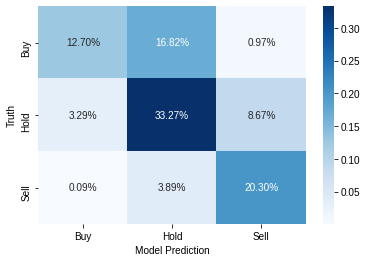

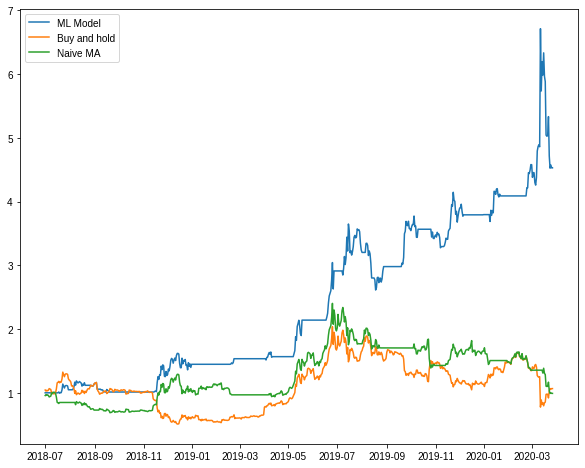

In [49]:
# LSTM walkforward model

# ticker = next(it)
# ticker = 'BTC'
print("Ticker",ticker)
data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
df = pd.read_csv(data_dir)
df['12_100EMA'] = df['12EMA'] / df['100EMA'] 
df['50_100EMA'] = df['50EMA'] / df['100EMA'] 
features_considered  = ['close', 'high', 'low', 'open', 'volumeto',
      '12_100EMA','50_100EMA', '100EMA', 'minusDI',
      'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal',
      'BB_hband', 'BB_lband', 'ATR', 'ADI', 'MFI']
# features_considered  = ['close', 'high', 'low', 'open']
features, outcome = preprocess_dataframe(df, features_considered)
predictions, y_truth, histories,recalc_dates = make_walkforward_transfer_model(features, outcome)
get_accuracy_eval(df, predictions, y_truth, histories,recalc_dates)

Ticker BTC


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Total accuracy: 67.97961075069509


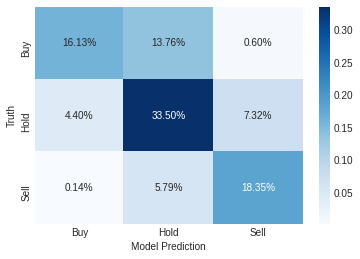

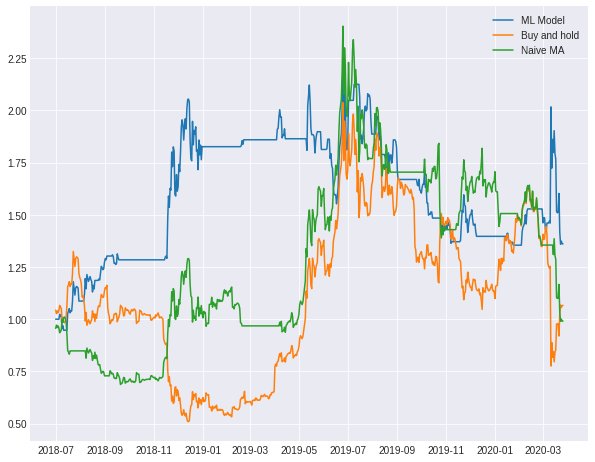

In [50]:
# CNN walk-forward model

# ticker = next(it)
# ticker = 'BTC'
print("Ticker",ticker)
data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
df = pd.read_csv(data_dir)
df['12_100EMA'] = df['12EMA'] / df['100EMA'] 
df['50_100EMA'] = df['50EMA'] / df['100EMA'] 
features_considered  = ['close', 'high', 'low', 'open', 'volumeto',
      '12_100EMA','50_100EMA', '100EMA', 'minusDI',
      'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal',
      'BB_hband', 'BB_lband', 'ATR', 'ADI', 'MFI']

features, outcome = preprocess_dataframe(df, features_considered)
predictions, y_truth, histories,recalc_dates = make_walkforward_transfer_CNN_model(features, outcome)
get_accuracy_eval(df, predictions, y_truth, histories,recalc_dates)

## Transfer learning from other cryptos

In [0]:
def make_walkforward_transfer_model2(features, outcome, model = None):
  # try:
  recalc_dates = features.resample('12M').mean().index.values[1:-1]
  models = pd.Series(index=recalc_dates, dtype = 'object')
  histories = pd.Series(index=recalc_dates, dtype = 'object')
  past_history = PAST_HISTORY
  first_run = True
  prev_date = None
  for date in recalc_dates:
    x_dataset = features.loc[slice(date-pd.Timedelta('360 days'),date)]
    y_dataset = outcome.loc[slice(date-pd.Timedelta('360 days'),date)]
    train_split_idx = int(x_dataset.shape[0]*0.9)
    train_split = train_split_idx
    x_dataset = preprocess_features(x_dataset,train_split)
    y_dataset = preprocess_outcome(y_dataset)
    
    x_train, y_train  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                    start_index = 0, end_index = train_split_idx, 
                                    history_size = past_history,
                                    )
    x_val, y_val  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                    start_index = train_split_idx-past_history, 
                                      end_index = None, 
                                    history_size = past_history,
                                    )
    train_data_single = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    val_data_single = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_data_single = val_data_single.batch(BATCH_SIZE).repeat()
    # create model
    if first_run == True:
      if model == None:
        model = create_model(x_train)
      else:
        model = model
      first_run = False
    else:
      model = models[prev_date]
    prev_date = date
    # train model
    model, history = fit_model(model,train_data_single,val_data_single)
    models.loc[date] = model
    histories.loc[date] = history

  begin_dates, end_dates = get_begin_end_dates(features,models,past_history)

  ## Generate OUT OF SAMPLE walk-forward predictions
  predictions = pd.Series(index=features.index)
  y_truth = pd.Series(index=features.index)

  for i,model in enumerate(models): #loop thru each models object in collection
    #         print(f'Using model trained on {begin_dates[i]}, Predict from: {begin_dates[i]} to: {end_dates[i]}')
    # print(i,begin_dates[i],end_dates[i])
    x_dataset = features.loc[slice(begin_dates[i],end_dates[i])]
    y_dataset = outcome.loc[slice(begin_dates[i],end_dates[i])]
    # Skip if number of observations input not enough
    if x_dataset.shape[0] < past_history:
      continue
    index = x_dataset.index[past_history:]
    train_split = int(x_dataset.shape[0]*1)
    x_dataset = preprocess_features(x_dataset,train_split)
    y_dataset = preprocess_outcome(y_dataset)
    train_split_idx = int(x_dataset.shape[0]*1)
    x_val, y_val  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                    start_index = 0, end_index = train_split_idx, 
                                    history_size = past_history,
                                    )

    prediction = model_predict(model, x_val)
    # print(i,prediction)
    p = pd.Series(prediction,index=index)
    predictions.loc[index] = p
    y_true = transform_y(y_val)
    y_truth.loc[index] = y_true
  # except:
  #   print("error occured")
  #   predictions = []
  #   y_truth = []

  return predictions, y_truth, model

In [0]:
def make_walkforward_transfer_CNN_model2(features, outcome, model = None):
  # try:
  recalc_dates = features.resample('12M').mean().index.values[1:-1]
  models = pd.Series(index=recalc_dates, dtype = 'object')
  histories = pd.Series(index=recalc_dates, dtype = 'object')
  past_history = PAST_HISTORY
  first_run = True
  prev_date = None
  for date in recalc_dates:
    x_dataset = features.loc[slice(date-pd.Timedelta('360 days'),date)]
    y_dataset = outcome.loc[slice(date-pd.Timedelta('360 days'),date)]
    train_split_idx = int(x_dataset.shape[0]*0.9)
    train_split = train_split_idx
    x_dataset = preprocess_features(x_dataset,train_split)
    y_dataset = preprocess_outcome(y_dataset)
    
    x_train, y_train  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                    start_index = 0, end_index = train_split_idx, 
                                    history_size = past_history,
                                    )
    x_val, y_val  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                    start_index = train_split_idx-past_history, 
                                      end_index = None, 
                                    history_size = past_history,
                                    )

    # create model
    if first_run == True:
      if model == None:
        model = create_CNN_model(x_train, y_train)
      else:
        model = model
      first_run = False
    else:
      model = models[prev_date]
    prev_date = date
    # train model
    model, history = fit_CNN_model(model,x_train, y_train,x_val, y_val)
    models.loc[date] = model
    histories.loc[date] = history

  begin_dates, end_dates = get_begin_end_dates(features,models,past_history)

  ## Generate OUT OF SAMPLE walk-forward predictions
  predictions = pd.Series(index=features.index)
  y_truth = pd.Series(index=features.index)

  for i,model in enumerate(models): #loop thru each models object in collection
    #         print(f'Using model trained on {begin_dates[i]}, Predict from: {begin_dates[i]} to: {end_dates[i]}')
    # print(i,begin_dates[i],end_dates[i])
    x_dataset = features.loc[slice(begin_dates[i],end_dates[i])]
    y_dataset = outcome.loc[slice(begin_dates[i],end_dates[i])]
    # Skip if number of observations input not enough
    if x_dataset.shape[0] < past_history:
      continue
    index = x_dataset.index[past_history:]
    train_split = int(x_dataset.shape[0]*1)
    x_dataset = preprocess_features(x_dataset,train_split)
    y_dataset = preprocess_outcome(y_dataset)
    train_split_idx = int(x_dataset.shape[0]*1)
    x_val, y_val  = multivariate_data(dataset = x_dataset, target = y_dataset,
                                    start_index = 0, end_index = train_split_idx, 
                                    history_size = past_history,
                                    )

    prediction = CNN_model_predict(model, x_val)
    # print(i,prediction)
    p = pd.Series(prediction,index=index)
    predictions.loc[index] = p
    y_true = transform_y(y_val)
    y_truth.loc[index] = y_true
  # except:
  #   print("error occured")
  #   predictions = []
  #   y_truth = []

  return predictions, y_truth, model

In [0]:
# tickers2 = ['ETH', 'DOGE', 'DASH', "NMC", "PPC", "NVC", "FTC", "WDC"]
tickers2 = ['ETH', 'DOGE', 'DASH', "NMC"]
initial_ticker = 'LTC'

In [0]:
print("Now appending",initial_ticker)
data_dir = glob.glob(processed_data_dir+initial_ticker+"_processed.csv")[0]
df = pd.read_csv(data_dir)
df['12_100EMA'] = df['12EMA'] / df['100EMA'] 
df['50_100EMA'] = df['50EMA'] / df['100EMA'] 
features, outcome = preprocess_dataframe(df, features_considered)
predictions, y_truth, model = make_walkforward_transfer_CNN_model2(features, outcome)

Now appending LTC


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [0]:
for ticker in tickers2:
  if ticker == 'BTC':
    print("Skipping BTC")
    continue
    print("double check: skipping BTC")

  print("Now appending",ticker)
  data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
  df = pd.read_csv(data_dir)
  df['12_100EMA'] = df['12EMA'] / df['100EMA'] 
  df['50_100EMA'] = df['50EMA'] / df['100EMA'] 
  features, outcome = preprocess_dataframe(df, features_considered)
  try:
    _, _, model = make_walkforward_transfer_CNN_model2(features, outcome, model)
  except:
    continue

Now appending ETH


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Now appending DOGE
Now appending DASH


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


Now appending NMC


### Putting model into BTC

In [0]:
ticker = 'BTC'
# ticker = 'SPX'
data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
df = pd.read_csv(data_dir)
df.head()

,time,close,high,low,open,volumefrom,volumeto,ret_holding,15SMA,SMA_ret_holding1,buy_signal,sell_signal,hold_signal,close_ret,12EMA,50EMA,100EMA,minusDI,plusDI,MACD,RSI,StoOsci,StoOsci_signal,BB_hband,BB_lband,ATR,ADI,MFI
0,2013-04-11,124.90,188.7,110.20,165.0,118747.72,18867223.23,-0.063251,133.710000,0.015367,1,0,0,-0.243030,145.284333,87.712684,60.798513,19.204489,28.229613,2.618666,52.534220,12.516431,30.091575,213.472003,60.737997,30.593601,1.095791e+08,62.609170
1,2013-04-12,117.00,140.0,54.25,124.9,556468.03,47619189.45,-0.205128,135.764667,0.001228,0,0,1,-0.063251,140.932898,88.861206,61.911414,27.806557,22.955601,-1.440933,50.594625,-29.038179,-2.600867,211.884738,66.110976,34.533343,1.316533e+08,52.254324
2,2013-04-13,93.00,130.0,85.50,117.0,238347.58,26277415.26,-0.032258,135.931333,-0.001074,0,0,1,-0.205128,133.558606,89.023512,62.527030,25.146848,20.759888,-5.680621,45.141858,-6.093979,-7.538576,211.795017,66.316412,35.245247,1.142335e+08,47.746081
3,2013-04-14,90.00,110.0,84.44,93.0,166274.96,16197017.56,-0.084556,135.785333,-0.005224,0,1,0,-0.032258,126.857282,89.061805,63.071049,23.959408,19.586011,-8.457816,44.496306,-17.387097,-17.506418,212.140937,65.537634,34.553444,1.050830e+08,45.445031
4,2013-04-15,82.39,102.0,71.51,90.0,236673.01,20607774.11,-0.170288,135.076000,-0.017590,0,1,0,-0.084556,120.016161,88.800166,63.453602,25.223837,18.243578,-10.447686,42.823364,-23.820312,-15.767130,214.284307,60.307122,34.263198,9.918256e+07,41.923978


In [0]:
df['12_100EMA'] = df['12EMA'] / df['100EMA'] 
df['50_100EMA'] = df['50EMA'] / df['100EMA'] 

# features_considered  = ['close', 'high', 'low', 'open','volumeto']

# features_considered  = ['close', 'high', 'low', 'open','volumeto',
#                         '12_100EMA','50_100EMA',
#                         'MACD','minusDI','plusDI']
features_considered  = ['close', 'high', 'low', 'open', 'volumeto',
       '12_100EMA','50_100EMA', '100EMA', 'minusDI',
       'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal',
       'BB_hband', 'BB_lband', 'ATR', 'ADI', 'MFI']

In [0]:
def preprocess_features(features,train_split):
  
  x_dataset = features.values

  # standardize the dataset using the mean and standard deviation of the training data.
  data_mean = x_dataset[:train_split].mean(axis=0)
  data_std = x_dataset[:train_split].std(axis=0)
  x_dataset = (x_dataset-data_mean)/data_std

  # standardize the x_dataset using minmax scaler
  # data_max = x_dataset[:train_split].max(axis=0)
  # data_min = x_dataset[:train_split].min(axis=0)
  # x_dataset = (x_dataset-data_min)/(data_max - data_min)

  # Wavelet transform
  coeffs, freqs = pywt.cwt(x_dataset,scales=np.arange(1,2),wavelet='morl')
  x_dataset = coeffs.reshape(-1, coeffs.shape[-1])

  return x_dataset

In [0]:
# features_considered  = ['close', 'high', 'low', 'open', 'volumefrom', 'volumeto',
#        '12EMA', '50EMA', '100EMA', 'minusDI',
#        'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal',
#        'BB_hband', 'BB_lband', 'ATR', 'ADI', 'MFI']


features, outcome = preprocess_dataframe(df, features_considered)
predictions, y_truth, _ = make_walkforward_transfer_CNN_model2(features, outcome, model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [0]:
pred_table = pd.merge(predictions.rename('Pred'),y_truth.rename('y_truth'),left_index=True,right_index=True)
pred_table.dropna(inplace=True)

In [0]:
# accuracy_matrix = confusion_matrix(pred_table['y_truth'], pred_table['Pred'])
# accuracy_matrix

# Accuracy matrix
label_dict = {0:"Buy", 1:"Sell", 2:"Hold"}
y_true_label = [label_dict[x] for x in pred_table['y_truth']]
predict_valid_label = [label_dict[x] for x in pred_table['Pred']]

acc_mtx_labels = np.unique(y_true_label)

accuracy_matrix = confusion_matrix(y_true_label, predict_valid_label, labels = acc_mtx_labels)
pd.DataFrame(accuracy_matrix, index=acc_mtx_labels, columns=acc_mtx_labels)
# accuracy_matrix

,Buy,Hold,Sell
Buy,0,0,658
Hold,0,0,976
Sell,0,0,524


In [0]:
# Accuracy for all signals
accuracy_matrix_percentage = accuracy_matrix / accuracy_matrix.astype(np.float).sum()
print('Total accuracy:', np.trace(accuracy_matrix_percentage)*100)

Total accuracy: 24.28174235403151


Text(0.5, 15.0, 'Model Prediction')

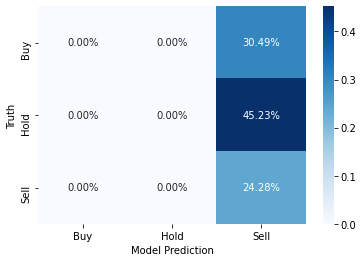

In [0]:
# Confusion Matrix Heatmap
acc_df = pd.DataFrame(accuracy_matrix_percentage, index=acc_mtx_labels, columns=acc_mtx_labels)
ax = sns.heatmap(acc_df,  
            fmt='.2%', cmap='Blues',annot=True)
# X - Y axis labels
ax.set_ylabel('Truth')
ax.set_xlabel('Model Prediction')

In [0]:
pred_table.head()

,Pred,y_truth
time,,
2014-04-30,1.0,1.0
2014-05-01,1.0,1.0
2014-05-02,1.0,1.0
2014-05-03,1.0,1.0
2014-05-04,1.0,1.0


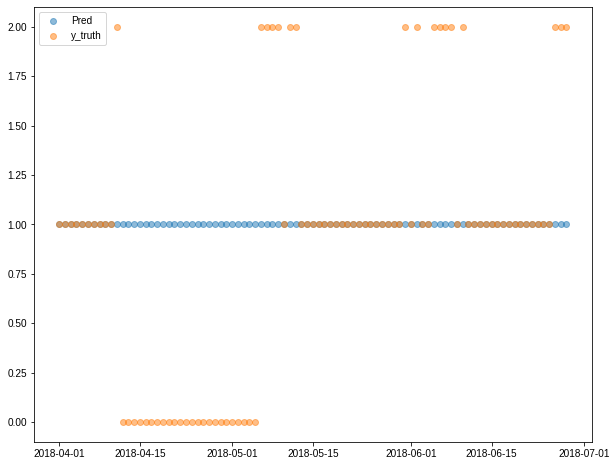

In [0]:
pred_table_plt = pred_table.loc['4/1/2018':'6/28/2018']
plt.figure(figsize=(10, 8))
# plt.plot(df.index, df['close'], label = 'Close')
plt.scatter(pred_table_plt.index, pred_table_plt['Pred'], label = 'Pred',alpha=0.5)
plt.scatter(pred_table_plt.index, pred_table_plt['y_truth'], label = 'y_truth',alpha=0.5)
# plt.plot(df.index, df['MACD'], label = 'MACD')
plt.legend()
plt.style.use('seaborn-darkgrid')

### P&L Simulation

In [0]:
df_eval = df[['time','close','12EMA','50EMA','100EMA']].copy()
# df_eval['time'] = pd.to_datetime(df_eval['time'])
# df_eval = df_eval[df_eval['time'] > "2015-01-01"]
df_eval.set_index('time',inplace=True)
df_eval = df_eval.loc['7/1/2018':]
df_eval.head()

,close,12EMA,50EMA,100EMA
time,,,,
7/1/2018,6339.04,6306.443649,7083.790207,7766.218771
7/2/2018,6615.66,6354.015395,7065.432160,7743.435429
7/3/2018,6509.58,6377.948411,7043.634036,7719.002648
7/4/2018,6590.06,6410.580963,7025.846819,7696.647348
7/5/2018,6534.81,6429.693123,7006.590473,7673.640668


In [0]:
df_eval = pd.merge(df_eval, pred_table, left_index=True, right_index=True)
# df_eval.dropna(inplace=True)
df_eval.head()

,close,12EMA,50EMA,100EMA,Pred,y_truth
time,,,,,,
2018-07-01,6339.04,6306.443649,7083.790207,7766.218771,0.0,0.0
2018-07-02,6615.66,6354.015395,7065.432160,7743.435429,0.0,0.0
2018-07-03,6509.58,6377.948411,7043.634036,7719.002648,0.0,0.0
2018-07-04,6590.06,6410.580963,7025.846819,7696.647348,0.0,0.0
2018-07-05,6534.81,6429.693123,7006.590473,7673.640668,0.0,0.0


In [0]:
df_eval['position'] = np.where(df_eval['Pred']==0,1,np.where(df_eval['Pred'] == 1,-1,np.nan))
df_eval['position'] = df_eval['position'].fillna(method='ffill')
df_eval['position'] = df_eval['position'].fillna(0)
df_eval['daily_ret'] = df_eval['close'] / df_eval['close'].shift(1) -1 
df_eval['daily_ret'] = df_eval['daily_ret'].fillna(0)
df_eval['port_ret'] = df_eval['position'] * df_eval['daily_ret']
df_eval['port_ret'] = df_eval['port_ret'].fillna(0)
df_eval['cum_ret'] = np.cumprod(1+df_eval['port_ret'])
df_eval['buy_and_hold'] = np.cumprod(1+df_eval['daily_ret'])

# Benchmark model
df_eval['bm_signal'] = np.where((df_eval['12EMA'] > df_eval['50EMA']) & (df_eval['50EMA'] > df_eval['100EMA']), 0, np.where((df_eval['12EMA'] < df_eval['50EMA']) & (df_eval['50EMA'] < df_eval['100EMA']), 1,2))
df_eval['bm_position'] = np.where(df_eval['bm_signal']==0,1,np.where(df_eval['bm_signal'] == 1,-1,np.nan))
df_eval['bm_position'] = df_eval['bm_position'].fillna(method='ffill')
df_eval['bm_position'] = df_eval['bm_position'].fillna(0)
df_eval['bm_port_ret'] = df_eval['bm_position'] * df_eval['daily_ret']
df_eval['bm_cum_ret'] = np.cumprod(1+df_eval['bm_port_ret'])

# Ideal model
df_eval['ideal_position'] = np.where(df_eval['y_truth']==0,1,np.where(df_eval['y_truth'] == 1,-1,np.nan))
df_eval['ideal_position'] = df_eval['ideal_position'].fillna(method='ffill')
df_eval['ideal_position'] = df_eval['ideal_position'].fillna(0)
df_eval['ideal_port_ret'] = df_eval['ideal_position'] * df_eval['daily_ret']
df_eval['ideal_cum_ret'] = np.cumprod(1+df_eval['ideal_port_ret'])

df_eval.tail()

,close,12EMA,50EMA,100EMA,Pred,y_truth,position,daily_ret,port_ret,cum_ret,buy_and_hold,bm_signal,bm_position,bm_port_ret,bm_cum_ret,ideal_position,ideal_port_ret,ideal_cum_ret
time,,,,,,,,,,,,,,,,,,
2020-03-22,5828.15,6184.406766,7748.461133,8149.698925,0.0,0.0,1.0,-0.059282,-0.059282,0.919406,0.919406,1,-1.0,0.059282,0.662061,1.0,-0.059282,220.118897
2020-03-23,6503.53,6233.502648,7699.640304,8117.101520,0.0,0.0,1.0,0.115882,0.115882,1.025949,1.025949,1,-1.0,-0.115882,0.585340,1.0,0.115882,245.626803
2020-03-24,6767.18,6315.606856,7663.073233,8090.370401,0.0,0.0,1.0,0.040540,0.040540,1.067540,1.067540,1,-1.0,-0.040540,0.561611,1.0,0.040540,255.584396
2020-03-25,6694.21,6373.853494,7625.078597,8062.723661,0.0,0.0,1.0,-0.010783,-0.010783,1.056029,1.056029,1,-1.0,0.010783,0.567666,1.0,-0.010783,252.828449
2020-03-26,6757.95,6432.945264,7591.073554,8036.886558,0.0,0.0,1.0,0.009522,0.009522,1.066084,1.066084,1,-1.0,-0.009522,0.562261,1.0,0.009522,255.235796


In [0]:
# df_eval.iloc[250:300]

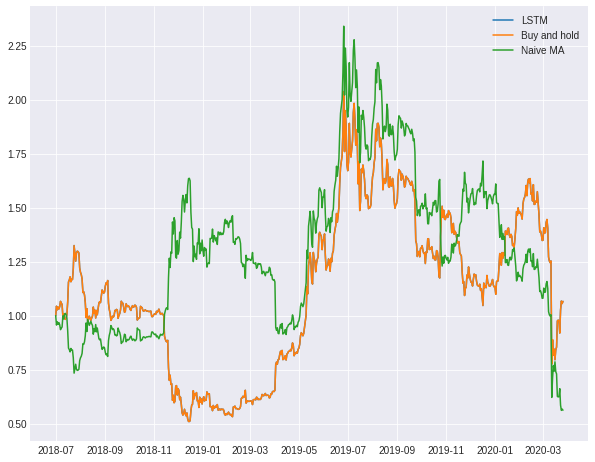

In [0]:
plt.figure(figsize=(10, 8))
plt.plot(df_eval.index, df_eval['cum_ret'], label = 'LSTM')
plt.plot(df_eval.index, df_eval['buy_and_hold'], label = "Buy and hold")
plt.plot(df_eval.index, df_eval['bm_cum_ret'], label = "Naive MA")
# plt.plot(df_eval.index, df_eval['ideal_cum_ret'], label = "Ideal")
plt.legend()
plt.style.use('seaborn-darkgrid')

## LSTM General performance on all cryptos

In [0]:
# LSTM General performance on all cryptos
multiple_pred = []
multiple_ytruth = []
for ticker in tickers:
  print("Ticker",ticker)
  data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
  df = pd.read_csv(data_dir)
  df['12_100EMA'] = df['12EMA'] / df['100EMA'] 
  df['50_100EMA'] = df['50EMA'] / df['100EMA'] 
  features_considered  = ['close', 'high', 'low', 'open', 'volumeto',
      '12_100EMA','50_100EMA', '100EMA', 'minusDI',
      'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal',
      'BB_hband', 'BB_lband', 'ATR', 'ADI', 'MFI']
  features, outcome = preprocess_dataframe(df, features_considered)
  predictions, y_truth, _,_ = make_walkforward_transfer_model(features, outcome)
  multiple_pred.append(predictions)
  multiple_ytruth.append(y_truth)

Ticker BTC
Epoch 1/10
200/200 [==============================] - 2s 10ms/step - loss: 4.0342 - accuracy: 0.7845 - val_loss: 15.5140 - val_accuracy: 0.0588
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 2.6986 - accuracy: 0.8341 - val_loss: 15.6604 - val_accuracy: 0.0588
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 2.6536 - accuracy: 0.8357 - val_loss: 15.9068 - val_accuracy: 0.0588
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 2.6344 - accuracy: 0.8368 - val_loss: 15.9140 - val_accuracy: 0.0588
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 2.6488 - accuracy: 0.8358 - val_loss: 15.9183 - val_accuracy: 0.0588
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 2.6583 - accuracy: 0.8352 - val_loss: 15.9210 - val_accuracy: 0.0588
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 2.6368 - accuracy: 0.8365 - val_loss: 15.9228 - val_accu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Ticker ETH
Epoch 1/10
200/200 [==============================] - 2s 10ms/step - loss: 4.7848 - accuracy: 0.7375 - val_loss: 12.8911 - val_accuracy: 0.3200
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 3.7731 - accuracy: 0.7751 - val_loss: 12.8923 - val_accuracy: 0.3200
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 3.6278 - accuracy: 0.7826 - val_loss: 12.8938 - val_accuracy: 0.3200
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 3.5656 - accuracy: 0.7864 - val_loss: 12.8941 - val_accuracy: 0.3200
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 3.6923 - accuracy: 0.7791 - val_loss: 12.8940 - val_accuracy: 0.3200
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 3.5736 - accuracy: 0.7855 - val_loss: 12.8942 - val_accuracy: 0.3200
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 3.5909 - accuracy: 0.7844 - val_loss: 12.8943 - val_accu

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


200/200 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.3322 - val_loss: nan - val_accuracy: 0.2857
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.3333 - val_loss: nan - val_accuracy: 0.2857
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.3334 - val_loss: nan - val_accuracy: 0.2857
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.3341 - val_loss: nan - val_accuracy: 0.2857
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.3328 - val_loss: nan - val_accuracy: 0.2857
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.3327 - val_loss: nan - val_accuracy: 0.2857
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.3331 - val_loss: nan - val_accuracy: 0.2857
Epoch 8/10
200/200 [==============================] - 1s 7m

In [0]:
pred_results = []
ytruth_results = []
for i in range(1,len(tickers)):
  if len(multiple_pred[i]) == 0:
    continue
  pred_table = pd.merge(multiple_pred[i].rename('Pred'),multiple_ytruth[i].rename('y_truth'),left_index=True,right_index=True)
  pred_table.dropna(inplace=True)
  pred_results.append(pred_table['Pred'].tolist())
  ytruth_results.append(pred_table['y_truth'].tolist())

In [0]:
pred_result = [item for sublist in pred_results for item in sublist]
ytruth_result = [item for sublist in ytruth_results for item in sublist]

In [0]:
# accuracy_matrix = confusion_matrix(pred_table['y_truth'], pred_table['Pred'])
# accuracy_matrix

# Accuracy matrix
label_dict = {0:"Buy", 1:"Sell", 2:"Hold"}
y_true_label = [label_dict[x] for x in pred_result]
predict_valid_label = [label_dict[x] for x in ytruth_result]

acc_mtx_labels = np.unique(y_true_label)

accuracy_matrix = confusion_matrix(y_true_label, predict_valid_label, labels = acc_mtx_labels)
pd.DataFrame(accuracy_matrix, index=acc_mtx_labels, columns=acc_mtx_labels)
# accuracy_matrix

,Buy,Hold,Sell
Buy,2847,1596,1000
Hold,1149,1945,1090
Sell,681,1626,3495


In [0]:
# Accuracy for all signals
accuracy_matrix_percentage = accuracy_matrix / accuracy_matrix.astype(np.float).sum()
print('Total accuracy:', np.trace(accuracy_matrix_percentage)*100)

Total accuracy: 53.710545077451556


Text(0.5, 15.0, 'Model Prediction')

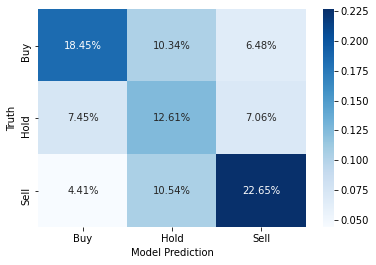

In [0]:
# Confusion Matrix Heatmap
acc_df = pd.DataFrame(accuracy_matrix_percentage, index=acc_mtx_labels, columns=acc_mtx_labels)
ax = sns.heatmap(acc_df,  
            fmt='.2%', cmap='Blues',annot=True)
# X - Y axis labels
ax.set_ylabel('Truth')
ax.set_xlabel('Model Prediction')

## CNN General Performance on All Cryptos

In [0]:
# CNN General performance on all cryptos
multiple_pred = []
multiple_ytruth = []
for ticker in tickers:
  print("Ticker",ticker)
  data_dir = glob.glob(processed_data_dir+ticker+"_processed.csv")[0]
  df = pd.read_csv(data_dir)
  df['12_100EMA'] = df['12EMA'] / df['100EMA'] 
  df['50_100EMA'] = df['50EMA'] / df['100EMA'] 
  features_considered  = ['close', 'high', 'low', 'open', 'volumeto',
      '12_100EMA','50_100EMA', '100EMA', 'minusDI',
      'plusDI', 'MACD', 'RSI', 'StoOsci', 'StoOsci_signal',
      'BB_hband', 'BB_lband', 'ATR', 'ADI', 'MFI']
  features, outcome = preprocess_dataframe(df, features_considered)
  predictions, y_truth, _,_ = make_walkforward_transfer_CNN_model(features, outcome)
  multiple_pred.append(predictions)
  multiple_ytruth.append(y_truth)

Ticker BTC


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Ticker ETH
Ticker DOGE
Ticker DASH


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


Ticker LTC
Ticker NMC
Ticker PPC
Ticker NVC
Ticker FTC
Ticker WDC


In [0]:
pred_results = []
ytruth_results = []
for i in range(1,len(tickers)):
  if len(multiple_pred[i]) == 0:
    continue
  pred_table = pd.merge(multiple_pred[i].rename('Pred'),multiple_ytruth[i].rename('y_truth'),left_index=True,right_index=True)
  pred_table.dropna(inplace=True)
  pred_results.append(pred_table['Pred'].tolist())
  ytruth_results.append(pred_table['y_truth'].tolist())

In [0]:
pred_result = [item for sublist in pred_results for item in sublist]
ytruth_result = [item for sublist in ytruth_results for item in sublist]

In [0]:
# accuracy_matrix = confusion_matrix(pred_table['y_truth'], pred_table['Pred'])
# accuracy_matrix

# Accuracy matrix
label_dict = {0:"Buy", 1:"Sell", 2:"Hold"}
y_true_label = [label_dict[x] for x in pred_result]
predict_valid_label = [label_dict[x] for x in ytruth_result]

acc_mtx_labels = np.unique(y_true_label)

accuracy_matrix = confusion_matrix(y_true_label, predict_valid_label, labels = acc_mtx_labels)
pd.DataFrame(accuracy_matrix, index=acc_mtx_labels, columns=acc_mtx_labels)
# accuracy_matrix

,Buy,Hold,Sell
Buy,2818,917,274
Hold,603,1707,512
Sell,929,1889,4133


In [0]:
# Accuracy for all signals
accuracy_matrix_percentage = accuracy_matrix / accuracy_matrix.astype(np.float).sum()
print('Total accuracy:', np.trace(accuracy_matrix_percentage)*100)

Total accuracy: 62.8210709621245


Text(0.5, 15.0, 'Model Prediction')

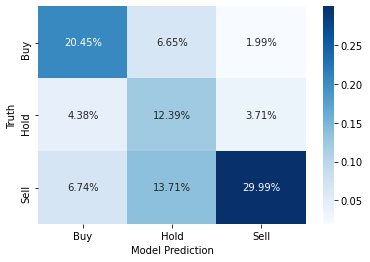

In [0]:
# Confusion Matrix Heatmap
acc_df = pd.DataFrame(accuracy_matrix_percentage, index=acc_mtx_labels, columns=acc_mtx_labels)
ax = sns.heatmap(acc_df,  
            fmt='.2%', cmap='Blues',annot=True)
# X - Y axis labels
ax.set_ylabel('Truth')
ax.set_xlabel('Model Prediction')